### testing

In [4]:
import numpy as np
import torch

In [5]:
df = np.random.uniform(2 * (5 + 1), 10 * 5)
Sigma_true = torch.distributions.Wishart(
    df=df, covariance_matrix=torch.eye(5)
).sample((2,))*(df - 5 - 1)

Z = torch.randn(2, 100, 5)
L = torch.linalg.cholesky(Sigma_true)
R = L @ Z.transpose(1, 2)  # (B, N, T)

/Users/Utilisateur1/finance/covariance-cleaning/.venv/lib/python3.11/site-packages/torch/distributions/wishart.py:279: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [6]:
from data.dataloader import make_random_pattern_vecto
from data.dataloader import torch_cov_pairwise

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
R_hat, _, mask = make_random_pattern_vecto(R)  # (B, N, T), (B, N), (B, N, T)

In [ ]:
Sigma_hat = torch_cov_pairwise(
    R_hat
)

NameError: name 'Sigma_hat' is not defined

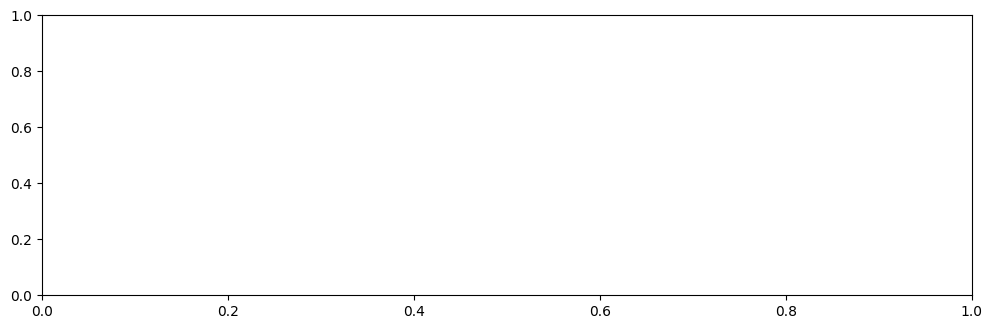

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[0], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[0]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[1], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[1]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

In [ ]:
eigvals, eigvecs = torch.linalg.eigh(Sigma_hat)

In [ ]:
eigvals_desc = torch.flip(eigvals, dims=[1])  # (B, N)
eigvecs_desc = torch.flip(eigvecs, dims=[2])  # (B, N, N)
eigvecs_desc

tensor([[[ 0.8435,  0.1555,  0.0241, -0.3570, -0.3693],
         [-0.0645,  0.0691,  0.2499, -0.7419,  0.6150],
         [-0.4829,  0.4988,  0.2936, -0.2981, -0.5856],
         [ 0.2184,  0.3085,  0.7681,  0.4614,  0.2328],
         [-0.0591, -0.7919,  0.5107, -0.1428, -0.2971]],

        [[ 0.1997,  0.3998,  0.0791,  0.8080, -0.3758],
         [ 0.7617,  0.1577, -0.2314, -0.4285, -0.3973],
         [ 0.1374, -0.4486, -0.7935,  0.3465,  0.1738],
         [-0.0952, -0.7031,  0.2556,  0.0416, -0.6554],
         [ 0.5933, -0.3461,  0.4952,  0.2045,  0.4911]]])

In [ ]:
Tmin = mask.float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)
Tmax = mask.flip(dims=[2]).float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)

In [ ]:
Tmin.transpose(1,2)

tensor([[[ 0,  8, 12, 33, 41]],

        [[ 0, 10, 19, 22, 30]]])

In [8]:
Tmax.transpose(1,2)

NameError: name 'Tmax' is not defined

In [9]:
eigvecs_desc.transpose(1, 2).pow(2) @ Tmin.float()

NameError: name 'eigvecs_desc' is not defined

[39 39 38 38 39]


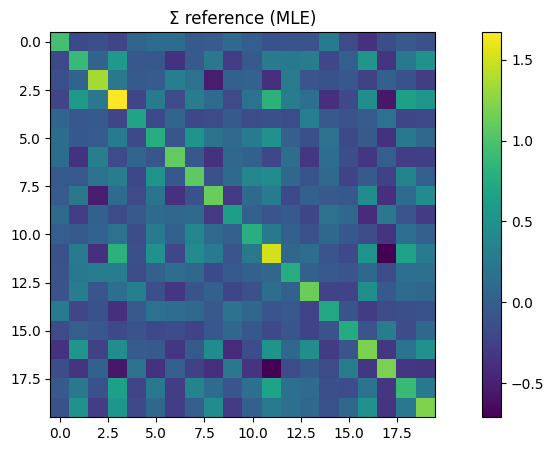

In [10]:
import scipy.stats as st
import matplotlib.pyplot as plt
N = 20
T = 40 # lots of noices if small
df = np.random.randint( 2* (N -1), 2 * N, size=5)  # degrees of freedom for invwishart
mat = st.invwishart.rvs(df=(df[0]), scale=np.eye(N))*(df[0]-N-1)
print(df)
plt.figure(figsize=(12,5))
plt.imshow(mat, cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [11]:
df

array([39, 39, 38, 38, 39])

In [12]:
invwishart_sampler = np.vectorize(lambda x: st.invwishart.rvs(df=x, scale=np.eye(N))*(x-N-1), signature='()->(n,n)')
Sigma_true = invwishart_sampler(df)
Sigma_true = torch.tensor(Sigma_true, dtype=torch.float32)

In [13]:
#Sigma_true = torch.eye(N)
#Sigma_true = Sigma_true.expand(5, N, N).clone()

In [14]:
L = torch.linalg.cholesky(Sigma_true)
Z = torch.randn(5, T, N).transpose(1, 2)
R = L @ Z

In [15]:
# no missing data
Rc = R - R.mean(dim=1, keepdim=True)
cov = Rc @ Rc.transpose(1,2) / (T - 1)
cov.size()

torch.Size([5, 20, 20])

In [16]:
((Sigma_true - cov) ** 2).mean(dim=(1,2)) 

tensor([0.0417, 0.0337, 0.0600, 0.0641, 0.0243])

tensor([0.0100, 0.0100, 0.0113, 0.0118, 0.0095])
vs
tensor([0.0583, 0.0534, 0.0560, 0.0655, 0.0529]) q big N/T

In [17]:
eigs_real, _ = torch.linalg.eigh(Sigma_true)
eigs_approx, _ = torch.linalg.eigh(cov)

In [18]:
((eigs_real - eigs_approx) ** 2).mean(dim=(1)) 

tensor([0.2177, 0.1601, 0.2011, 0.0751, 0.0710])

tensor([0.1857, 0.4791, 0.4030, 0.1478, 0.3203])
vs
tensor([5.8104, 6.8074, 7.2211, 8.1183, 6.0892])

On a test file I am trying to observe when the MLE (without missingness) becomes bad 

In [19]:
from data.real_dataloader import real_data_pipeline

In [88]:
dataset = real_data_pipeline(
    1000,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = T,
    n_days_in = T,
    shift = 0,
    n_stocks = N,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [89]:
(rin_tf, nan_mask), rout_tf = next(iter(dataset))

In [90]:
rin = torch.from_numpy(rin_tf.numpy())
rout = torch.from_numpy(rin_tf.numpy())

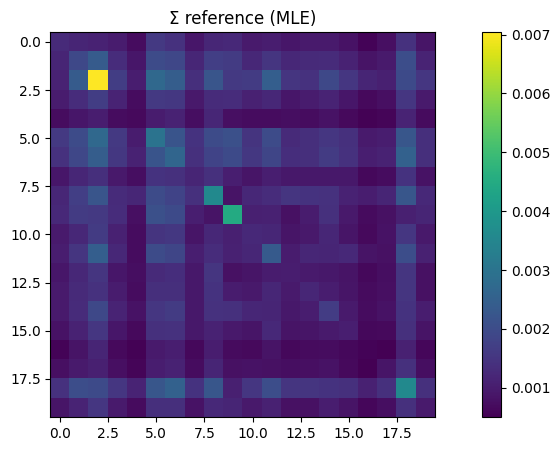

In [91]:
plt.figure(figsize=(12,5))
plt.imshow(rout[0].cov(), cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [92]:
mean = 0
for i in range(500):
    S = scale=np.eye(N)
    nu_hat = np.trace(np.linalg.solve(rout[0].cov(), S)) / N
    mean += nu_hat/500

In [93]:
mean

np.float64(9120.42659573671)